## Import Modules

In [16]:
import cv2
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tkinter import filedialog
from tkinter import *
from PIL import Image, ImageTk

## Load the Dataset

In [17]:
TRAIN_DIR = '../input/facial-expression-dataset/train/train/'
TEST_DIR = '../input/facial-expression-dataset/test/test/'

In [18]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [19]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/train/train...,sad
1,../input/facial-expression-dataset/train/train...,happy
2,../input/facial-expression-dataset/train/train...,neutral
3,../input/facial-expression-dataset/train/train...,fear
4,../input/facial-expression-dataset/train/train...,sad


In [20]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


## Exploratory Data Analysis

<AxesSubplot:xlabel='label', ylabel='count'>

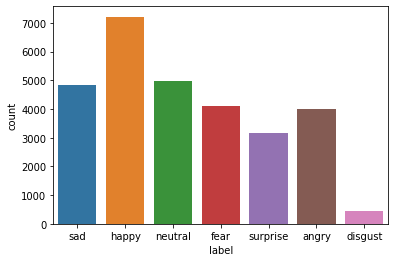

In [21]:
sns.countplot(train['label'])

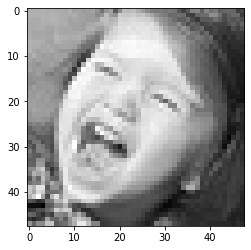

In [22]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

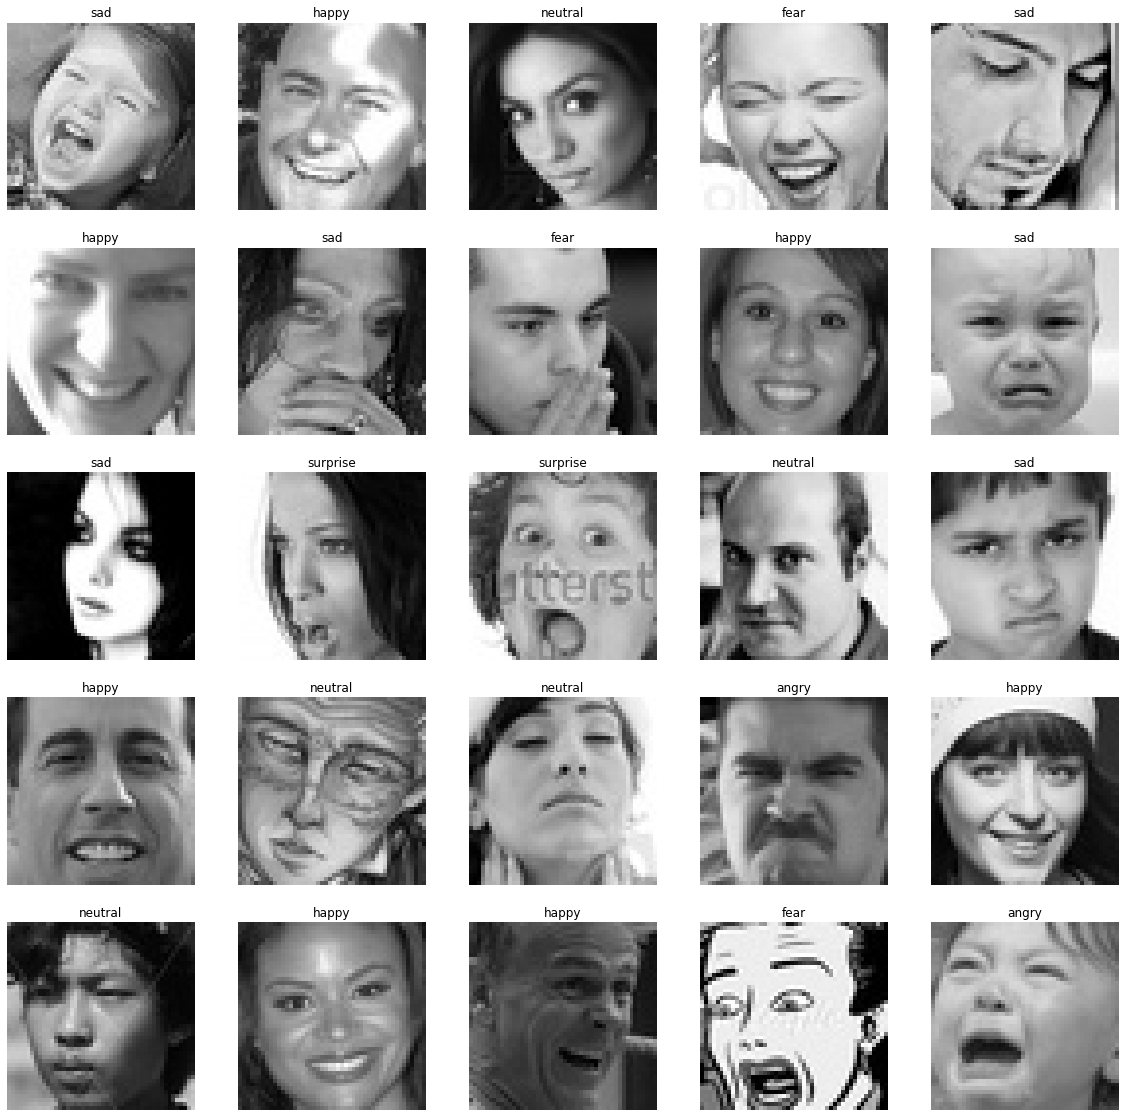

In [23]:
# to display grid of images
plt.figure(figsize=(20,
                    20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [24]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [25]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [26]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [27]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [28]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [29]:
# Save the label encoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

SyntaxError: invalid character in identifier (2826813344.py, line 3)

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

## Plot the Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [ ]:
# Load the label encoder
with open('label_encoder.pkl', 'rb') as file:
    le = pickle.load(file)

In [ ]:
# Testing with user input image
def predict_user_image(model, encoder):
    from tkinter import filedialog
    from tkinter import Tk
    root = Tk()
    root.withdraw()  # Prevent Tkinter window from appearing
    file_path = filedialog.askopenfilename()
    img = load_img(file_path, color_mode='grayscale', target_size=(48, 48))
    img_array = np.array(img).reshape(1, 48, 48, 1) / 255.0
    pred = model.predict(img_array)
    prediction_label = encoder.inverse_transform([pred.argmax()])[0]
    print("Predicted Output:", prediction_label)
    plt.imshow(img_array.reshape(48, 48), cmap='gray')
    plt.show()

In [ ]:
predict_user_image(model, le)

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.save("FER.h5")